# **Tutorial on Text as Data**: Text Representation

Source:  [https://github.com/d-insight/code-bank.git](https://github.com/d-insight/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

---

## Overview

There are different ways to represent text data. In this notebook, we will dig deeper into the subject and look at different approaches to transform the text into its respective numerical representation.



## Part 1: Text representation with TF-IDF

In the previous notebook, we used a very simple solution to represent text data: by counting the most common words. One of the drawbacks of this approach is that all terms receive the same weights.

A better strategy is to weight words according to their occurrence in the document. The underline idea is that words that appear in every document probably do not bring any particular meaning to the topic.

To do that we normalize the term frequency of the world by the inverse of the document frequency. This might sound complicated at first. In this section, we will break down the TF-IDF algorithm step by step on a simple example.


> ☝️scikit-learn provides a function to easily compute TF-IDF weights. At the end of our custom solution, we will compare the two solutions to make sure they return the same value.

![images/tf-idf-image](./images/tf-idf.png)

Assume we are given the following reviews and we want to compute the TF-IDF weights.

In [1]:
review_0 = "the pizza was very very good quality"
review_1 = "the pasta was very superior quality"
review_2 = "the gnocchi weren't that good"

Q1: First, using `scikit-learn`, compute the count term-vector matrix and save it into a DataFrame `df_count`.

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="\S+")

reviews = [review_0, review_1, review_2]

count_cv = cv.fit_transform(reviews).toarray()

df_count = pd.DataFrame(count_cv, columns=cv.get_feature_names())
df_count

,gnocchi,good,pasta,pizza,quality,superior,that,the,very,was,weren't
0,0,1,0,1,1,0,0,1,2,1,0
1,0,0,1,0,1,1,0,1,1,1,0
2,1,1,0,0,0,0,1,1,0,0,1


Q2: Now, we need to compute the `idf` part. For each term, count the total number of documents that contain such a term (`document_freq`). In the literature, this is known as "document frequency".

In [3]:
document_freq = (df_count != 0).sum()
document_freq

gnocchi     1
good        2
pasta       1
pizza       1
quality     2
superior    1
that        1
the         3
very        2
was         2
weren't     1
dtype: int64

Q3: Compute the `idf` part:

\begin{align}
idf(word_i) = ln(\frac{n+1}{document\_freq(word_i) + 1}) + 1
\end{align}

Example

\begin{align}
idf(very) = ln(\frac{3+1}{2 + 1}) + 1 = ln(4/3) + 1 \approx 1.29
\end{align}

In [4]:
import numpy as np
n = df_count.shape[0]
idf = np.log((n + 1) / (document_freq + 1)) + 1
idf

gnocchi     1.693147
good        1.287682
pasta       1.693147
pizza       1.693147
quality     1.287682
superior    1.693147
that        1.693147
the         1.000000
very        1.287682
was         1.287682
weren't     1.693147
dtype: float64

Q4: Finnally, compute the TF-IDF (`tfidf`) weights

In [5]:
tfidf = df_count * idf
tfidf

,gnocchi,good,pasta,pizza,quality,superior,that,the,very,was,weren't
0,0.000000,1.287682,0.000000,1.693147,1.287682,0.000000,0.000000,1.0,2.575364,1.287682,0.000000
1,0.000000,0.000000,1.693147,0.000000,1.287682,1.693147,0.000000,1.0,1.287682,1.287682,0.000000
2,1.693147,1.287682,0.000000,0.000000,0.000000,0.000000,1.693147,1.0,0.000000,0.000000,1.693147


Q5: Now we can compare our solution with scikit-learn and see if they are the same.

> ☝️Note that by default scikit-learn normalize the output. To avoid that, we need to pass `norm=None`.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

reviews = [review_0, review_1, review_2]

vectorizer = TfidfVectorizer(token_pattern="\S+", min_df=1, norm=None)

m = vectorizer.fit_transform(reviews).toarray()

tfidf_sklearn = pd.DataFrame(m, columns=vectorizer.get_feature_names())
tfidf_sklearn

,gnocchi,good,pasta,pizza,quality,superior,that,the,very,was,weren't
0,0.000000,1.287682,0.000000,1.693147,1.287682,0.000000,0.000000,1.0,2.575364,1.287682,0.000000
1,0.000000,0.000000,1.693147,0.000000,1.287682,1.693147,0.000000,1.0,1.287682,1.287682,0.000000
2,1.693147,1.287682,0.000000,0.000000,0.000000,0.000000,1.693147,1.0,0.000000,0.000000,1.693147


In [7]:
tfidf_sklearn == tfidf

,gnocchi,good,pasta,pizza,quality,superior,that,the,very,was,weren't
0,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True


Q6: Explain why the outputs of `CountVectorizer` and `TfidfVectorizer` are sparse matrix. What's the main advantage of using sparse representation? 

**Answer**

Recall that the rows of the matrix represents the document (in this case reviews) whereas the columns are terms (i.e tokens/words). Clearly, not all documents contain all words of the vocabulary, and therefore most of the values are zero. Instead of returning the full matrix composed of many zeros, we return a special data structure (i.e a sparse matrix) containing only non-zero values plus the information regarding the position in the matrix. This way we can save a lot of memory.      

Q7 (**homework**): Go back to Notebook 2, part 3 and compute again the topic, this time using `TfidfVectorizer` instead of `CountVectorizer`. Does the topics are better defined? (spoiler: **yes**).

## Part 2: Word2Vec

Word2vec is a two-layer neural networks to vectorize words. Its input is a text corpus and its output is a set of vectors, feature vectors that represent words in that corpus.


**Learning objective**: intuitively understand Word2Vec and be able to implement it

**Useful resources**:
 - [Word2vec paper: Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
 - [The Illustrated Word2vec](http://jalammar.github.io/illustrated-word2vec/)

Q1: By looking at the following image, can you explain the difference between the continuous-bag-of-words (CBOW) and skip-gram model architectures?

![images/cbow vs skip-gram](./images/cbow-vs-skip-gram.pbm)

**Answer**

**CBOW**: given a context, predict the word

**Skip-gram**: given as input a single word, predict the context

Q2: We will now train a Word2Vec model using [Gensim](https://radimrehurek.com/gensim/). Gensim's Word2Vec expect as input a list of sentences where each sentence is a list of tokens as in the example below. Load `review_clean.csv` into a Pandas Dataframe `df`, transform it as a list of list of tokens and store it into a variable called `corpus`.

> ☝️ For tokenization, you can simply use `string.split()`

In [8]:
sentence_one = ["Resturant", "was", "ok", "."]
sentence_two = ["Restaurant", "was", "average"]

valid_gensim_input = [sentence_one, sentence_two]

print(valid_gensim_input)

[['Resturant', 'was', 'ok', '.'], ['Restaurant', 'was', 'average']]


In [9]:
df = pd.read_csv("./data/review_clean.csv")
df.head(2)

,text_clean,text,stars,categories,name,address
0,Omar great ! diagnose correct cell phone issu...,Omar is great! He can diagnose and correct an...,5.0,"Mobile Phones, Shopping, Telecommunications, M...",T-Mobile,"16635 N Tatum Blvd, Ste 110"
1,TERRIBLE ! ! ! went salon close proximity waxi...,TERRIBLE!!! I went to this salon due to its cl...,1.0,"Day Spas, Beauty & Spas, Nail Salons",Pretty Nails,1660 E Camelback Rd


In [10]:
# Split into sentences
sentences_s = df['text_clean'].str.split(".").explode()

# Split each sentence into tokens
tokens_s = sentences_s.str.split()

# Concatenate all list togethers
corpus = list(tokens_s)
corpus[:2]

[['Omar',
  'great',
  '!',
  'diagnose',
  'correct',
  'cell',
  'phone',
  'issue',
  '-',
  'professional',
  'patient',
  '-',
  'ideal',
  'buyers',
  '/',
  'customers',
  'limited',
  'technology',
  'knowledge'],
 ['Thank', 'Omar', 'help']]

Q3: Define and train the `word2vec` model. Set the embedding `size` to 300, train using the skip-gram model and set `min_count` to 5.

> ☝️ Have a look at the [Gensim Word2Vec tutorial](https://radimrehurek.com/gensim/models/word2vec.html) for help

In [11]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(size=300, sg=1, min_count=5)


w2v_model.build_vocab(corpus, progress_per=10000)


w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)

(9089505, 11248120)

Q4: Once the model is trained we can extract the word embeddings and compare it. Execute the cell below to create a DataFrame that map selected words to their Word2Vec vector.

In [12]:
list_of_words = ["pasta", "pizza", "spaghetti", "car", "insurance", "phone", "technology"]

dict_ = {}

for word in list_of_words:
    dict_[word] = [w2v_model.wv[word]]

df_vocab = pd.DataFrame(dict_).T.reset_index().rename(columns={0: 'vector', 'index': 'vocab'})
df_vocab

,vocab,vector
0,pasta,"[0.16100411, -0.44462204, 0.09203769, 0.131131..."
1,pizza,"[0.5975063, -0.54391915, 0.5388808, 0.19324102..."
2,spaghetti,"[0.34720272, -0.29686236, 0.26158643, 0.001025..."
3,car,"[0.3174404, -0.41663548, 0.5467024, 0.7372491,..."
4,insurance,"[-0.38761958, -0.23813048, -0.011089393, 0.336..."
5,phone,"[0.088869356, -0.2655629, 0.335964, 0.91946524..."
6,technology,"[-0.09345005, -0.18767874, 0.06817056, 0.36209..."


Q5: using Texthero `pca` and `scatterplot` functions, apply principal component analysis and visualize the vector space. Can you spot anything interesting?

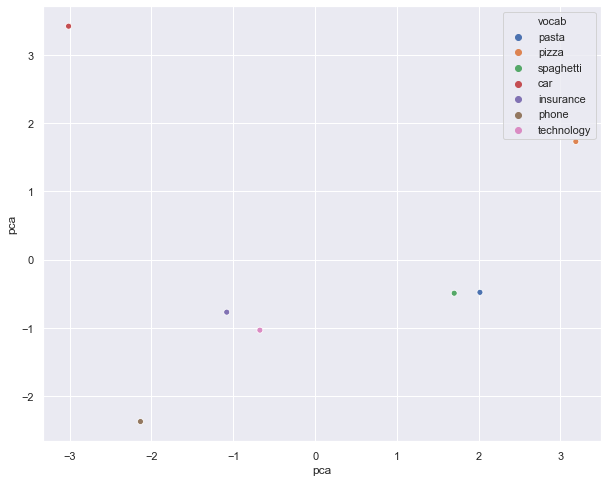

In [13]:
import texthero as hero

df_vocab['pca'] = hero.pca(df_vocab['vector'])
#hero.scatterplot(df_vocab, 'pca', color='vocab')

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10, 8

import seaborn as sns; sns.set()
import seaborn
seaborn.scatterplot(x=df_vocab['pca'].str[0], y=df_vocab['pca'].str[1], hue=df_vocab['vocab']);

#hero.scatterplot(df, 'pca', color='stars');

## Part 3: Subwords and contextualized word embeddings

Word2Vec has been around for about a decade now. Word2Vec has some limitations, for instance it cannot handle words not present in the vocabulary used during training.


**Papers**: 

- [Elmo: deep contextualized word representations](https://arxiv.org/pdf/1802.05365.pdf)
- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)

**Resources and extra lectures**: 

- [How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec)
[ELMo vs. BERT vs. Word2vec vs. GloVe](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe)

Q1: What are the main differences between Word2Vec and FastText ?

**Answer**

- Word2vec treat words as the smallest unit to train on
- FastText treats each word as **composed of character ngrams**
- FastText generates better word embeddings for rare words
- FastText work with out–of–vocabulary (oov) words

Q2: What's the main difference between Word2vec/Glove and Elmo?

**Answer**

- Word2Vec (and Glove) word embeddings are context independent
- With Elmo, the same word in two different context will have different vectors
- Word2vec and Glove do not take into account word order in their training
- Once trained, we can discard model with Word2Vec and Glove but we need to keep it with Elmo.

We will now represent all review using Glove. To do so, we will make use of [Flair](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md), a recently published python package that allow to easily represent any text using different embeddings.

Q3: Using `WordEmbeddings('glove')` represent the word `analytics`, `business` and `pizza`. Then compute the cosine distance between vectors. Which ones are closer?

In [14]:
from scipy.spatial import distance

from flair.embeddings import WordEmbeddings
from flair.data import Sentence
glove_embedding = WordEmbeddings('glove')

analytics = Sentence('analytics')
glove_embedding.embed(analytics)
analytics_np = analytics[0].embedding.numpy()

business = Sentence('business')
glove_embedding.embed(business)
business_np = business[0].embedding.numpy()

pizza = Sentence('pizza')
glove_embedding.embed(pizza)
pizza_np = pizza[0].embedding.numpy()

print("distance analytics-business: ", distance.cosine(analytics_np, business_np))
print("distance analytics-pizza: ", distance.cosine(analytics_np, pizza_np))

distance analytics-business:  0.6769274473190308
distance analytics-pizza:  0.9892289051786065


Until now we represented only single words, but what if we want to represent documents? Here you are asked to represent 10'000 different reviews, and sort them with respect to their cosine distance to the first review.

Q4: First, define a function `embed_review` that given a review it returns the respective embed. For this part, you can use [Document Pool Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_5_DOCUMENT_EMBEDDINGS.md) from Flair: `DocumentPoolEmbeddings([glove_embedding])`.
Test your function with the following review: "Restaurant was fabolous".

In [15]:
from flair.embeddings import DocumentPoolEmbeddings

docpoolembed = DocumentPoolEmbeddings([glove_embedding])

def embed_review(review):
    s = Sentence(review)
    docpoolembed.embed(s)
    return s.embedding.numpy()

embed_review("Restaurant was fabolous")

array([ 8.66933241e-02, -5.56396663e-01,  1.20346665e-01, -1.11973338e-01,
        1.04716666e-01,  3.58339958e-02,  4.94163364e-01,  4.51049991e-02,
        3.79222989e-01,  4.73299980e-01,  8.33370015e-02,  4.71833386e-02,
        3.73263329e-01, -2.21253335e-01,  2.71760017e-01,  3.98333259e-02,
        2.60616988e-01, -3.92656654e-01, -6.09496653e-01,  2.15656683e-01,
        3.42953324e-01,  1.41179338e-01,  9.83295068e-02, -5.61051071e-01,
        1.99090004e-01,  1.69324994e-01, -3.80899996e-01, -2.18599990e-01,
       -1.28083333e-01, -2.39233430e-02, -1.43140003e-01,  6.18003309e-01,
        2.43299320e-01,  5.81566632e-01,  6.24503382e-02,  2.65113324e-01,
       -5.40033318e-02,  1.77274346e-01,  2.21469685e-01, -4.31127310e-01,
        4.97676700e-01,  2.52333283e-02,  2.41698742e-01,  1.04423344e-01,
        5.22879660e-01,  2.40914330e-01, -2.45366693e-01, -1.21610999e-01,
        4.70633358e-01, -4.67902035e-01, -4.40006644e-01, -2.33179986e-01,
        1.93666723e-02,  

Q5: Apply to the `text` column your previously created method and store the result in a new column `embed`. 

> ☝️This operation might take a while, we use `tqdm` to show a progress bar.

In [16]:
from tqdm import tqdm
tqdm.pandas()

df.reset_index(inplace=True)

df['embed'] = df['text_clean'].progress_apply(embed_review)
df['embed']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 10000/10000 [00:24<00:00, 405.18it/s]


0       [-0.14973384, 0.105061956, 0.35441896, -0.0065...
1       [0.0014385143, 0.14520112, 0.2159496, -0.34776...
2       [-0.19049452, 0.20583253, 0.2609278, -0.240894...
3       [-0.18839265, 0.33528236, 0.24974221, -0.26905...
4       [-0.12573816, 0.31910342, 0.14125381, -0.14221...
                              ...                        
9995    [-0.22443968, 0.33964384, 0.3370281, -0.230378...
9996    [-0.21270736, 0.21685344, 0.30420268, -0.26460...
9997    [-0.108463414, 0.16915984, 0.37964147, -0.3303...
9998    [-0.12619269, 0.06759783, 0.20094448, -0.12893...
9999    [-0.03584042, 0.09587897, 0.33155766, -0.27944...
Name: embed, Length: 10000, dtype: object

Q6: Sort the review by cosine distance w.r.t the first review and visualize on screen the first three reviews. Do they look similar?

> ☝️ The function below compute the cosine similarity between a vector and every row of the given numpy matrix. You will need to use `np.array(list(df['embed']))` to transform the Pandas Series into a NumPy matrix.

In [17]:
import scipy

def cosine_similarity(vector, matrix):
    """
    Compute the cosine distances between the vector and each row of the matrix.
    """
    
    print(matrix.shape)
    
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

In [18]:
first_review_vec = df.iloc[0]['embed']
df['cosine_similarity'] = cosine_similarity(first_review_vec, np.array(list(df['embed'])))

most_similar = df.sort_values('cosine_similarity')[:3]
for i, review in most_similar.iterrows():
    print(review['text'])
    print("\n")

(10000, 100)
Omar is great!  He can diagnose and correct any cell phone issue - professional and patient - ideal for buyers/customers with limited technology knowledge.  Thank you Omar for all your help.  Jana and Lorraine


Just wanna quick thanks to the person repair my laptop, its working great and faster than ever before. Also, the information provided to me is the greatest thing and i know  how to keep up the machine up-to-date. Thanks again


They person/company they sent out to provide a quote didn't even show up at the scheduled time.  No call or e-mail in advance.  Will never use this company if they can't even get that part right.  Embarrassed for them!




Q7: Look now at the farthest review. What's that about?

In [19]:
df.sort_values('cosine_similarity')['text'].iloc[-1]

'挺不错的 味道都挺好 食物卖相也不错 唯一遗憾蒸蛋没啦 跑来中国城吃饭 周围也蛮好停车的 点了一个面一个红油抄手 一个小菜 又送了一个木耳 酸酸辣辣的 很多地方的红油抄手都会偏甜 就感觉很不正宗 但是他们家的完全不会 所以觉得很好哦 然后面里的炒黄豆很好吃'